In [7]:
#  
import pandas as pd
data = pd.read_csv('./US_Accidents_Dec19.csv')
datacopy = data.copy()
datacopy['Start_Time'] = pd.to_datetime(datacopy['Start_Time'])
datacopy['year'] = datacopy['Start_Time'].apply(lambda x:x.year)
data1 = datacopy[datacopy['year']==2019]
data1.to_csv('./USaccident2019.csv')


In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import pandas as pd
import  webbrowser
from pyecharts import options as opts
from pyecharts.charts import Page, Pie, Bar, Line, Scatter
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [2]:
data = pd.read_csv('./USaccident2019.csv')
data.shape #(953630, 51)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953630 entries, 0 to 953629
Data columns (total 51 columns):
Unnamed: 0               953630 non-null int64
ID                       953630 non-null object
Source                   953630 non-null object
TMC                      691922 non-null float64
Severity                 953630 non-null int64
Start_Time               953630 non-null object
End_Time                 953630 non-null object
Start_Lat                953630 non-null float64
Start_Lng                953630 non-null float64
End_Lat                  261708 non-null float64
End_Lng                  261708 non-null float64
Distance(mi)             953630 non-null float64
Description              953629 non-null object
Number                   354730 non-null float64
Street                   953630 non-null object
Side                     953630 non-null object
City                     953611 non-null object
County                   953630 non-null object
State               

In [3]:
data.isnull().sum()[data.isnull().sum()!=0]

TMC                      261708
End_Lat                  691922
End_Lng                  691922
Description                   1
Number                   598900
City                         19
Zipcode                     342
Timezone                   1451
Airport_Code               2307
Weather_Timestamp         11690
Temperature(F)            17184
Wind_Chill(F)            149234
Humidity(%)               18266
Pressure(in)              13795
Visibility(mi)            18481
Wind_Direction            19974
Wind_Speed(mph)           60083
Precipitation(in)        219122
Weather_Condition         18283
Sunrise_Sunset               22
Civil_Twilight               22
Nautical_Twilight            22
Astronomical_Twilight        22
dtype: int64

In [4]:
# missing value
# delete the useless columns
deletelist= ['Unnamed: 0', 'ID','TMC', 'End_Lat', 'End_Lng', 'Airport_Code','Weather_Timestamp','Wind_Chill(F)',
             'Civil_Twilight', 'Nautical_Twilight',
             'Astronomical_Twilight', 'year','Number']
data1 = data.drop(deletelist, axis=1)
# delete the nan columns
data1 = data1.dropna(axis = 0,subset=['City','Zipcode','Timezone','Sunrise_Sunset'])
# mean full up
data1['Temperature(F)'] = data1['Temperature(F)'].fillna(data1['Temperature(F)'].mean())
data1['Humidity(%)'] = data1['Humidity(%)'].fillna(data1['Humidity(%)'].mean())
data1['Pressure(in)'] = data1['Pressure(in)'].fillna(data1['Pressure(in)'].mean())
data1['Visibility(mi)'] = data1['Visibility(mi)'].fillna(data1['Visibility(mi)'].mean())
# nearest full up
data1['Wind_Speed(mph)'] = data1['Wind_Speed(mph)'].interpolate(method='nearest', order=4)
#common full up
data1['Weather_Condition'] = data1['Weather_Condition'].fillna(data1['Weather_Condition'].mode())
data1['Wind_Direction'] = data1['Wind_Direction'].fillna(data1['Wind_Direction'].mode())
#0 to full up
data1['Precipitation(in)'] = data1['Precipitation(in)'].fillna(0)
# merge wit same mean
occupation = {"CALM":"Calm", "N":"North", "S":"South", "W":"West", "E":"East", "VAR":"Variable"}
f = lambda x : occupation.get(x,x) #
data1['Wind_Direction']= data1['Wind_Direction'].map(f)
#
data1.index = range(len(data1))


In [5]:
# Most accident State
a=(
    Bar(init_opts=opts.InitOpts(width="2000px",height="400px"))
.add_xaxis(data1['State'].value_counts().index.tolist())
.add_yaxis('Number of Accidents',data1['State'].value_counts().tolist(),color='#499C9F')
.set_series_opts(label_opts=opts.LabelOpts(is_show= False))
)
a.render_notebook()
###   the accident usually happened in developed place.

In [6]:
# Accicent happen time
x1=pd.DatetimeIndex(data1["Start_Time"]).hour.value_counts().sort_index().index.tolist()
x=[str(i) for i in x1] #pyehchart need char
from pyecharts.charts import Line
b = (Line(init_opts=opts.InitOpts(width="1000px",height="400px"))
     .add_xaxis(x)
    .add_yaxis('numbers for each time',pd.DatetimeIndex(data1["Start_Time"]).hour.value_counts().sort_index().tolist() ,color='#F7BA0B',is_smooth=True)
    .set_series_opts(label_opts=opts.LabelOpts(is_show= False), markarea_opts=opts.MarkAreaOpts(
            data=[opts.MarkAreaItem(name="Morning", x=("6", "9")),opts.MarkAreaItem(name="Evening", x=("15", "18"))]))
     .set_global_opts(xaxis_opts=opts.AxisOpts(name='time/h',name_location = "center",name_gap= 40))
    )
b.render_notebook()
### clearly the accident ususally happened in travel time on work.

In [7]:
# Month
x1=pd.DatetimeIndex(data1["Start_Time"]).month.value_counts().sort_index().index.tolist()
x=[str(i) for i in x1] #
from pyecharts.charts import Line
q = (Line(init_opts=opts.InitOpts(width="1000px",height="400px"))
     .add_xaxis(x)
    .add_yaxis('Accident in each month',pd.DatetimeIndex(data1["Start_Time"]).month.value_counts().sort_index().tolist() ,
               color='#AED54C',
               is_smooth=True,
               areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
              )
     .set_global_opts(xaxis_opts=opts.AxisOpts(name='month',name_location = "center",name_gap= 40))
    )
q.render_notebook()

# The number of accidents in the second half of the year is significantly higher than 
# that in the first half of the year, perhaps because there are more holidays and more workload in the second half of the year



In [8]:
# accident in each weather
weather10 = data1['Weather_Condition'].value_counts().head(10)
c=(
    Bar()
.add_xaxis(weather10.index.tolist())
.add_yaxis('number of accident in each weather',weather10.tolist(),color='#48A43F')
.set_series_opts(label_opts=opts.LabelOpts(is_show= False))
.set_global_opts(
xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-15))# long label
))
c.render_notebook()
##  Accident mostly happened in fair weather, but the ratio of weather is different, so I think on average (accident number/ weather number)
##  the bad weather might be high

In [14]:
# The weather = clear, the accident type
Clear_wearther = data1[:][data1['Weather_Condition']=='Fair']
occupation = {1:"slight", 2:"normal", 3:"big", 4:"huge"}
f = lambda x : occupation.get(x,x) #
Clear_wearther['Severity']= Clear_wearther['Severity'].map(f)
Clear_wearther['Severity'].value_counts().index
d = (Pie()
        .add("hotel",[list(z) for z in zip(['slight', 'normal', 'big', 'huge'],Clear_wearther['Severity'].value_counts().tolist())])
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))
)
d.render_notebook()


In [13]:
Clear_wearther = data1[:][data1['Weather_Condition']=='Snow']
occupation = {1:"slight", 2:"normal", 3:"big", 4:"huge"}
f = lambda x : occupation.get(x,x) #
Clear_wearther['Severity']= Clear_wearther['Severity'].map(f)
Clear_wearther['Severity'].value_counts().index
d = (Pie()
        .add("hotel",[list(z) for z in zip(['slight', 'normal', 'big', 'huge'],Clear_wearther['Severity'].value_counts().tolist())])
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))
)
d.render_notebook()

In [15]:
# environment
# 1 is  daytime
m = lambda x : 1 if x=='Day' else 0
data1['Sunrise_Sunset'] = data1['Sunrise_Sunset'].apply(m)
# rain?
m = lambda x : 1 if x>0 else 0
data1['PrecipitationORnot'] = data1['Precipitation(in)'].apply(m)
df0=pd.concat([data1['Crossing'].value_counts()
               ,data1['PrecipitationORnot'].value_counts()
               ,data1['Sunrise_Sunset'].value_counts().sort_index()
               ,data1['Traffic_Signal'].value_counts()
               ,data1['Give_Way'].value_counts()
               ,data1['Bump'].value_counts()
              ],axis=1)

h = (
    Bar()
    .add_xaxis(['Crossing','PrecipitationORnot','Sunrise_Sunset','Traffic_Signal','Give_Way','Bump'])
    .add_yaxis("0", df0.loc[False].tolist(), stack="stack1",color='#992572')
    .add_yaxis("1",df0.loc[True].tolist(), stack="stack1",color='#4A203B')
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="Bar"))

)
h.render_notebook()
## Most of the accidents occurred during the day, not at the intersection, 
## no precipitation, no signal lights, no yield signs, no speed bumps

In [51]:
#Visibility when accident happened

data1["Visibility_bin"] = "low"
data1.loc[(data1["Visibility(mi)"]>2.5)&(data1["Visibility(mi)"]<=6.5), "Visibility_bin"] = "mid"
data1.loc[(data1["Visibility(mi)"]>6.5)&(data1["Visibility(mi)"]<=12), "Visibility_bin"] = "good"
data1.loc[(data1["Visibility(mi)"]>12), "Visibility_bin"] = "very good"
d = (Pie()
        .add("hotel",[list(z) for z in zip(['good', 'mid', 'low', 'very good'],data1["Visibility_bin"].value_counts().tolist())])
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))
         .set_global_opts(title_opts=opts.TitleOpts(title="Visibility"))

)
d.render_notebook()
## Most accidents have good visibility, ranging from 6.5 miles to 12 miles

In [52]:
# 
incidents = folium.map.FeatureGroup()
datasample=data1.sample(3000) 
# Loop through the 3000 accidents and add each to the incidents feature group
for lat, lng, in zip(datasample.Start_Lat,datasample.Start_Lng):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )

# Add incidents to map
US_map = folium.Map(location=[38, -100], zoom_start=4)
US_map.add_child(incidents)


In [100]:
dataX = data1.copy()
#
dataX['Start_Time'] = pd.to_datetime(dataX['Start_Time'],format='%Y-%m-%d %H:%M:%S')

In [101]:
dataX['month']=dataX['Start_Time'].apply(lambda x:x.month)
dataX['hour'] = dataX['Start_Time'].apply(lambda x:x.hour)

deletelist2=['Source','Side','Start_Time', 'End_Time','Description',
             'Street','City','County', 'State', 'Zipcode', 'Country', 'Timezone','Wind_Direction','PrecipitationORnot','Visibility_bin']
dataX = dataX.drop(deletelist2, axis=1)
#
list3=['Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop']
m = lambda x : 1 if x else 0
for i in list3:
    dataX[i] = dataX[i].apply(m)
# severity = 1 is less, delete
dataX = dataX.drop(index=(dataX.loc[(dataX['Severity']==1)].index))
dataX.index = range(len(dataX))
dataX.head()


,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,month,hour
0,2,41.848064,-71.062386,0.00,36.0,59.0,30.20,10.00,3.0,0.0,...,0,0,0,0,0,0,0,1,12,9
1,2,42.660690,-71.192589,0.00,36.0,55.0,30.04,10.00,0.0,0.0,...,0,0,0,0,0,0,0,1,12,12
2,2,42.157021,-71.069061,0.00,31.0,72.0,30.16,10.00,0.0,0.0,...,0,0,0,0,0,0,0,0,12,20
3,2,42.338776,-71.276962,0.00,26.0,81.0,30.04,10.00,0.0,0.0,...,0,0,0,0,0,0,0,0,12,20
4,3,42.379570,-83.200256,0.34,32.0,100.0,29.37,0.25,5.0,0.0,...,0,0,0,0,0,0,0,0,12,7


In [102]:
from sklearn.preprocessing import LabelEncoder
y = dataX['Severity']#
Xw=dataX['Weather_Condition']#1
X = dataX.drop(['Severity','Weather_Condition'],axis=1)
#
Xw

0                  Fair
1                  Fair
2         Mostly Cloudy
3                  Fair
4                   Fog
5                   Fog
6                  Fair
7                  Fair
8                  Fair
9                  Fair
10                 Fair
11                 Fair
12                 Fair
13        Partly Cloudy
14        Mostly Cloudy
15                 Fair
16                  NaN
17                 Fair
18                 Fair
19                  NaN
20                 Fair
21        Mostly Cloudy
22        Mostly Cloudy
23        Mostly Cloudy
24        Mostly Cloudy
25        Mostly Cloudy
26        Mostly Cloudy
27        Mostly Cloudy
28               Cloudy
29        Mostly Cloudy
              ...      
951925             Fair
951926             Fair
951927             Fair
951928             Fair
951929             Fair
951930             Fair
951931             Fair
951932             Fair
951933             Fair
951934             Fair
951935          

In [103]:
le = LabelEncoder().fit_transform(Xw.astype(str))


In [104]:
enc = OneHotEncoder().fit(le.reshape(-1,1))
result = enc.transform(le.reshape(-1,1)).toarray()
Xw1=pd.DataFrame(result)
Xw1.shape #(951955, 102)

(951955, 102)

In [105]:
### PCA
pca=PCA(n_components=5) 
pca.fit(Xw1)
col = pca.transform(Xw1)
Xw1 = pd.DataFrame(col)
Xw1.head()

,0,1,2,3,4
0,0.695294,0.026285,-0.018531,-0.035600,-0.014116
1,0.695294,0.026285,-0.018531,-0.035600,-0.014116
2,-0.484997,0.775379,-0.176509,-0.170540,-0.053642
3,0.695294,0.026285,-0.018531,-0.035600,-0.014116
4,-0.242028,-0.048910,0.043673,0.137357,0.081786


In [106]:
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951955 entries, 0 to 951954
Data columns (total 27 columns):
Severity             951955 non-null int64
Start_Lat            951955 non-null float64
Start_Lng            951955 non-null float64
Distance(mi)         951955 non-null float64
Temperature(F)       951955 non-null float64
Humidity(%)          951955 non-null float64
Pressure(in)         951955 non-null float64
Visibility(mi)       951955 non-null float64
Wind_Speed(mph)      951955 non-null float64
Precipitation(in)    951955 non-null float64
Weather_Condition    935128 non-null object
Amenity              951955 non-null int64
Bump                 951955 non-null int64
Crossing             951955 non-null int64
Give_Way             951955 non-null int64
Junction             951955 non-null int64
No_Exit              951955 non-null int64
Railway              951955 non-null int64
Roundabout           951955 non-null int64
Station              951955 non-null int64
Stop      

In [107]:
## Standardization
columns=X.columns.tolist()
robustS=RobustScaler()
X = pd.DataFrame(robustS.fit_transform(X),columns=columns)
X.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,month,hour
0,0.866576,0.606560,0.00,-0.962963,-0.228571,0.578947,0.00,-0.615385,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,-0.250
1,0.986282,0.602980,0.00,-0.962963,-0.342857,0.368421,0.00,-1.076923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.125
2,0.912088,0.606377,0.00,-1.148148,0.142857,0.526316,0.00,-1.076923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.833333,1.125
3,0.938862,0.600659,0.00,-1.333333,0.400000,0.368421,0.00,-1.076923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.833333,1.125
4,0.944871,0.272773,0.34,-1.111111,0.942857,-0.513158,-9.75,-0.307692,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.833333,-0.500


In [108]:
X1 = pd.concat([X,Xw1],axis = 1)
X1.shape 
#xgboost classification only accept start by 0 
def f(x):
    if x==2:
        return 0
    elif x==3:
        return 1
    else:
        return 2
y1 = y.apply(f)
y1.value_counts()


0    686240
1    237688
2     28027
Name: Severity, dtype: int64

In [109]:
param1 = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # multiple classification problem
    'num_class': 3,               # class numbers，use with multisoftmax 
    'gamma': 0.1,                  # The parameter used to control whether the post-pruning, the larger the more conservative, generally 0.1, 0.2 this way.
    'max_depth': 12,               # Build the depth of the tree, the larger the tree, the easier it is to over-fitting
    'lambda': 2,                   # The parameter of the L2 regularization term that controls the weight value of the model complexity, the larger the parameter, the less likely the model is to be overfitted.
    'subsample': 0.7,              # Randomly sampled training samples
    'colsample_bytree': 0.7,       # Column sampling during tree generation
    'min_child_weight': 3,
    'silent': 1,                   # If you set it to 1, no information will be output, and it is better to set it to 0.
    'eta': 0.007,                  # same like learn rate
    'seed': 1000,
    'nthread': 4,                  # cpu threads
}
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix( X_test, label=y_test)
bst1 = xgb.train(param1, xg_train)
pred1 = bst1.predict( xg_test )
print(accuracy_score(y_test, pred1))


[01:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7782287008862449


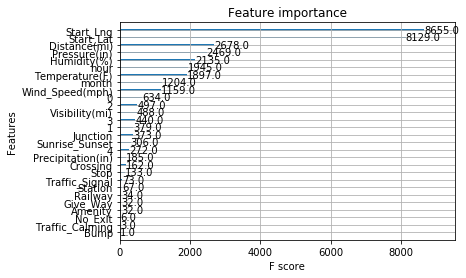

In [111]:
from xgboost import plot_importance
plot_importance(bst1)
plt.show()
